# Imports

In [21]:
import pandas as pd
import numpy as np
import gzip
import seaborn as sns
import matplotlib.pyplot as plt

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import spacy

# Load dataset into a dataframe

In [16]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')
# Import and tidy dataframe (drop nulls)
df = getDF('qa_Appliances.json.gz')
df = df.drop(columns=['asin','answerTime','unixTime'])

# EDA
### Create column with the extracted question word

In [17]:
qword_options = []
q_words = ['what', 'when', 'where', 'who', 'whom', 'which', 'whose', 'why', 'how', 'is', 'are', 'will', 'would', 'can', 'could', 'should', 'does', 'do', 'did', 'has', 'have', 'am', 'may'] # These are in order of priority when picking the question word
def extract_q(question):
    # for word in [p_stemmer.stem(x) for x in word_tokenize(question.lower())]:
    answer_list =  word_tokenize(question.lower())
    if bool(set(q_words) & set(answer_list)):
        word_out = [x for x in q_words if x in answer_list][0]
    else:
        word_out = np.nan
    return word_out

df['question_word'] = df['question'].apply(extract_q)
df['question_word'].value_counts()

,questionType,question,answerType,answer,question_word
0,yes/no,I have a 9 year old Badger 1 that needs replac...,?,I replaced my old one with this without a hitch.,will
1,open-ended,model number,NaN,This may help InSinkErator Model BADGER-1: Bad...,NaN
2,yes/no,can I replace Badger 1 1/3 with a Badger 5 1/2...,?,Plumbing connections will vary with different ...,can
3,yes/no,Does this come with power cord and dishwasher ...,?,It does not come with a power cord. It does co...,does
4,open-ended,loud noise inside when turned on. sounds like ...,NaN,Check if you dropped something inside.Usually ...,when


### Wordcloud for answers

In [ ]:
# Create dictionary of unique full counts, used for visualisation - single words
answer_clean_list = dict(answer_counts)
answer_clean_dictionary = {}
for k, v in answer_clean_list.items():
    if v > 10000:
        answer_clean_dictionary[k] = v
# Check
answer_clean_dictionary
# Word cloud for answers
wc = WordCloud(width=800, height=400, max_words=100).generate_from_frequencies(answer_clean_dictionary)
plt.figure(figsize=(24, 20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### EDA for n-grams of answers

In [ ]:
# initialise counts
answer_counts_ngrams2 = Counter()
answer_counts_ngrams3 = Counter()

# apply counts
df['bigrams'].apply(answer_counts_ngrams2.update)
df['trigrams'].apply(answer_counts_ngrams3.update)
# Create dictionary of unique full counts, used for visualisation - bigrams and tri words
answer_bigrams_list = dict(answer_counts_ngrams2)
answer_trigrams_list = dict(answer_counts_ngrams3)
anser_bi_dictionary = {}
answer_tri_dictionary = {}

for k, v in answer_bigrams_list.items():
    if v > 100:
        anser_bi_dictionary[k] = v

for k, v in answer_trigrams_list.items():
    if v > 100:
        answer_tri_dictionary[k] = v
# Word cloud for answers
wc = WordCloud(width=800, height=400, max_words=100).generate_from_frequencies(anser_bi_dictionary)
plt.figure(figsize=(24, 20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Word cloud for answers
wc = WordCloud(width=800, height=400, max_words=100).generate_from_frequencies(answer_tri_dictionary)
plt.figure(figsize=(24, 20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Processing

### Clean text for n-gram analysis

In [180]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" # emoticons
                               u"\U0001F300-\U0001F5FF" # symbols & pictographs
                               u"\U0001F680-\U0001F6FF" # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# Rigorous leaner for matching n-grams
def clean_text(text, is_question=True, stem=False, token=False):
    ''' Cleans and preprocesses the input text '''

    # Convert to lowercase
    text = text.lower()

    # Stop words test
    stop_words = set(stopwords.words('english'))

    # Removal of:
    punc = '!"#$%&()*+, -./:;<=>?@[\]^_`{|}~”“\''
    punc = [x for x in punc]
    text = re.sub(r'http\S+', '', text) # Urls
    text = re.sub(r'<.*?>', '', text) #Html tags
    text = remove_emoji(text) # emojis
    text = re.sub(r'(@.+?)\s', '', text)
    text = re.sub(r'(//t.co/.+?)\s', '', text)
    text = re.sub(r'(//t.co/.+?)', '', text)
    text = re.sub(r'\d+', '', text) # Numbers
    text = re.sub(r'[^\w\s]', '', text) # Special characters

    # Tokenize text into a sentance
    sentences = sent_tokenize(text)

    # Tokenize sentences into words
    tokens = []
    for sentence in sentences:
        tokens.extend(word_tokenize(sentence))

    # Remove stop stopwords
    # stop_words = set(stopwords.words('english'))
    if is_question:
        # Add question specific words
        stop_words.update(['who', 'what', 'where', 'when', 'why', 'how', 'which'])
    stop_words.update(['rt', '#', 'fav', '', ':', '@', '!', ';', '…','...', '(', ')', '~', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
    stop_words.update(punc)

    # Yes or no are useful?
    # stop_words.remove('yes')
    stop_words.remove('no')
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize or stem words
    if stem:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(token) for token in tokens]
    else:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Tokens into a string
    clean_text = ' '.join(tokens)
    clean_text = [word for word in clean_text if word not in stop_words]
    clean_text = ' '.join(tokens)

    if token:
        # Tokenize
        clean_text = word_tokenize(clean_text)

    return clean_text

# Lightweight cleaner to preserve finer information
def cleaner(text):

    text = re.sub('[!£$%^&*()_+{}:"|<>?~`,./;\[\]=-]',' ', text.lower())
    text = re.sub('[\']','', text.lower())

    text = word_tokenize(text)
    stpwrd = ['a', 'the', 'to', 'I', 'for']
    text = [word for word in text if word not in stpwrd]

    return ' '.join(text)

In [22]:
df['question_clean'] = df['question'].apply(clean_text)
df['answer_clean'] = df['answer'].apply(clean_text)
df.head()

,questionType,question,answerType,answer,question_word,question_clean,answer_clean
0,yes/no,I have a 9 year old Badger 1 that needs replac...,?,I replaced my old one with this without a hitch.,will,year old badger need replacing badger install ...,replaced old one without hitch
1,open-ended,model number,NaN,This may help InSinkErator Model BADGER-1: Bad...,NaN,model number,may help insinkerator model badger badger hp g...
2,yes/no,can I replace Badger 1 1/3 with a Badger 5 1/2...,?,Plumbing connections will vary with different ...,can,replace badger badger connection,plumbing connection vary different model usual...
3,yes/no,Does this come with power cord and dishwasher ...,?,It does not come with a power cord. It does co...,does,come power cord dishwasher hook,come power cord come dishwasher hookup
4,open-ended,loud noise inside when turned on. sounds like ...,NaN,Check if you dropped something inside.Usually ...,when,loud noise inside turned sound like blade loose,check dropped something insideusually wife put...


### Extract n-grams

In [31]:
# Idea is that the text is already cleaned
def extract_ngrams_2(text):
    doc = word_tokenize(text)
    ngrams = [str((doc[i], doc[i+1])) for i in range(len(doc)-1)]
    return ngrams

def extract_ngrams_3(text):
    doc = word_tokenize(text)
    ngrams = [str((doc[i], doc[i+1], doc[i+2])) for i in range(len(doc)-2)]
    return ngrams

df['question_bigram'] = df['question_clean'].apply(extract_ngrams_2)
df['question_trigram'] = df['question_clean'].apply(extract_ngrams_3)
df['answer_bigram'] = df['answer_clean'].apply(extract_ngrams_2)
df['answer_trigram'] = df['answer_clean'].apply(extract_ngrams_3)
df.head()

,questionType,question,answerType,answer,question_word,question_clean,answer_clean,question_bigram,question_trigram,answer_bigram,answer_trigram
0,yes/no,I have a 9 year old Badger 1 that needs replac...,?,I replaced my old one with this without a hitch.,will,year old badger need replacing badger install ...,replaced old one without hitch,"[('year', 'old'), ('old', 'badger'), ('badger'...","[('year', 'old', 'badger'), ('old', 'badger', ...","[('replaced', 'old'), ('old', 'one'), ('one', ...","[('replaced', 'old', 'one'), ('old', 'one', 'w..."
1,open-ended,model number,NaN,This may help InSinkErator Model BADGER-1: Bad...,NaN,model number,may help insinkerator model badger badger hp g...,"[('model', 'number')]",[],"[('may', 'help'), ('help', 'insinkerator'), ('...","[('may', 'help', 'insinkerator'), ('help', 'in..."
2,yes/no,can I replace Badger 1 1/3 with a Badger 5 1/2...,?,Plumbing connections will vary with different ...,can,replace badger badger connection,plumbing connection vary different model usual...,"[('replace', 'badger'), ('badger', 'badger'), ...","[('replace', 'badger', 'badger'), ('badger', '...","[('plumbing', 'connection'), ('connection', 'v...","[('plumbing', 'connection', 'vary'), ('connect..."
3,yes/no,Does this come with power cord and dishwasher ...,?,It does not come with a power cord. It does co...,does,come power cord dishwasher hook,come power cord come dishwasher hookup,"[('come', 'power'), ('power', 'cord'), ('cord'...","[('come', 'power', 'cord'), ('power', 'cord', ...","[('come', 'power'), ('power', 'cord'), ('cord'...","[('come', 'power', 'cord'), ('power', 'cord', ..."
4,open-ended,loud noise inside when turned on. sounds like ...,NaN,Check if you dropped something inside.Usually ...,when,loud noise inside turned sound like blade loose,check dropped something insideusually wife put...,"[('loud', 'noise'), ('noise', 'inside'), ('ins...","[('loud', 'noise', 'inside'), ('noise', 'insid...","[('check', 'dropped'), ('dropped', 'something'...","[('check', 'dropped', 'something'), ('dropped'..."


### Generate useful/unuseful/neutral score based on matches with useful/unuseful n-grams

In [156]:
useful_bi_words = ["('make', 'sure')", "('yes', 'works')", "('good', 'luck')", "('work', 'great')", "('feel', 'free')", "('worked', 'fine')", "('no', 'need')", "('worked', 'great')", "('would', 'recommend')", "('no', 'problem')", "('fit', 'perfectly')", "('fit', 'great')", "('please', 'let')", "('yes', 'it')", "('it', 'can')", "('couldnt', 'use')", "('dont', 'work')", "('yes', '.')", "('no', 'problem')", "('work', 'fine')", "('work', 'well')", "('fit', 'fine')", "('yes', 'use')", "('use', 'one')", "('would', 'recommend')", "('worked', 'perfectly')", "('would', 'fit')", "('mine', 'came')", "('hope', 'help')", "('inch', 'wide')", "('make', 'sure')", "('no', 'problem')", "('would', 'suggest')","('may', 'want')", "('hope', 'help')", "('hope', 'helped')", "('think', 'would')", "('make', 'sure')"]
useless_bi_words = ["('dont', 'know')", "('maybe', 'work')", "('potential', 'work')", "('sorry', 'dont')", "('am', 'sure')", "('dont', 'really')", "('really', 'know')", "('probably', 'maybe')", "('maybe', 'work')", "('dont', 'quite')", "('no', 'idea')", "('sorry', 'help')", "('think', 'would')", "('would', 'probably')"]

useful_tri_words = ["('inch', 'wide', 'inch')", "('feel', 'free', 'contact')", "('make', 'sure', 'get')", "('would', 'say', 'yes')", "('yes', 'no', 'problem')", "('work', 'really', 'well')", "('would', 'work', 'well')", "('would', 'highly', 'recommend')", "('think', 'would', 'work')", "('work', 'like', 'charm')", "('buy', 'another', 'one')", "('make', 'sure', 'get')", "('hope', 'information', 'help')"]
useless_tri_words = ["('sorry', 'dont', 'know')", "('please', 'let', 'know')", "('sorry', 'answer', 'question')", "('need', 'make', 'sure')", "('mine', 'work', 'great')", "('buy', 'another', 'one')"]

def score_answer_ngrams(answer_ngram, n):

    if n == 2:
        useful_count = sum([1 for i in answer_ngram if i in useful_bi_words])
        useless_count = sum([1 for i in answer_ngram if i in useless_bi_words])
    elif n == 3:
        useful_count = sum([1 for i in answer_ngram if i in useful_tri_words])
        useless_count = sum([1 for i in answer_ngram if i in useless_tri_words])

    try:
        useful_score = round((useful_count) / len(answer_ngram), 2)
        mid_score =  round((len(answer_ngram) - useless_count - useful_count) / len(answer_ngram),2)
        useless_score = round((useless_count) / len(answer_ngram), 2)
    except ZeroDivisionError:
        useful_score = 0
        mid_score = 0
        useless_score = 0

    return [useful_score, mid_score, useless_score]

df['bi_gram_score'] = df['answer_bigram'].apply(score_answer_ngrams, args=[2])
df['tri_gram_score'] = df['answer_trigram'].apply(score_answer_ngrams, args=[3])
df.head()

,questionType,question,answerType,answer,question_word,question_clean,answer_clean,question_bigram,question_trigram,answer_bigram,answer_trigram,bi_gram_score,tri_gram_score,sentiment_score,answer_light_clean,target_manual
0,yes/no,I have a 9 year old Badger 1 that needs replac...,?,I replaced my old one with this without a hitch.,will,year old badger need replacing badger install ...,replaced old one without hitch,"[('year', 'old'), ('old', 'badger'), ('badger'...","[('year', 'old', 'badger'), ('old', 'badger', ...","[('replaced', 'old'), ('old', 'one'), ('one', ...","[('replaced', 'old', 'one'), ('old', 'one', 'w...","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","(0.0, 1.0, 0.0)",i replaced my old one with this without hitch,0.950000
1,open-ended,model number,NaN,This may help InSinkErator Model BADGER-1: Bad...,NaN,model number,may help insinkerator model badger badger hp g...,"[('model', 'number')]",[],"[('may', 'help'), ('help', 'insinkerator'), ('...","[('may', 'help', 'insinkerator'), ('help', 'in...","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","(0.0, 1.0, 0.0)",this may help insinkerator model badger 1 badg...,0.900000
2,yes/no,can I replace Badger 1 1/3 with a Badger 5 1/2...,?,Plumbing connections will vary with different ...,can,replace badger badger connection,plumbing connection vary different model usual...,"[('replace', 'badger'), ('badger', 'badger'), ...","[('replace', 'badger', 'badger'), ('badger', '...","[('plumbing', 'connection'), ('connection', 'v...","[('plumbing', 'connection', 'vary'), ('connect...","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","(0.0, 1.0, 0.0)",plumbing connections will vary with different ...,0.629159
3,yes/no,Does this come with power cord and dishwasher ...,?,It does not come with a power cord. It does co...,does,come power cord dishwasher hook,come power cord come dishwasher hookup,"[('come', 'power'), ('power', 'cord'), ('cord'...","[('come', 'power', 'cord'), ('power', 'cord', ...","[('come', 'power'), ('power', 'cord'), ('cord'...","[('come', 'power', 'cord'), ('power', 'cord', ...","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","(0.0, 1.0, 0.0)",it does not come with power cord it does come ...,0.910811
4,open-ended,loud noise inside when turned on. sounds like ...,NaN,Check if you dropped something inside.Usually ...,when,loud noise inside turned sound like blade loose,check dropped something insideusually wife put...,"[('loud', 'noise'), ('noise', 'inside'), ('ins...","[('loud', 'noise', 'inside'), ('noise', 'insid...","[('check', 'dropped'), ('dropped', 'something'...","[('check', 'dropped', 'something'), ('dropped'...","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","(0.0, 1.0, 0.0)",check if you dropped something inside usually ...,0.861473


In [157]:
df.loc[:100,'bi_gram_score']

0        [0.0, 1.0, 0.0]
1        [0.0, 1.0, 0.0]
2        [0.0, 1.0, 0.0]
3        [0.0, 1.0, 0.0]
4        [0.0, 1.0, 0.0]
             ...        
96       [0.0, 1.0, 0.0]
97     [0.0, 0.95, 0.05]
98       [0.0, 1.0, 0.0]
99       [0.0, 1.0, 0.0]
100      [0.0, 1.0, 0.0]
Name: bi_gram_score, Length: 101, dtype: object

In [163]:
df.loc[92,['question','answer', 'bi_gram_score']]

question         Does it have screens in place where the vents ...
answer           No. The way it works is that the tray is about...
bi_gram_score                                   [0.02, 0.96, 0.02]
Name: 92, dtype: object

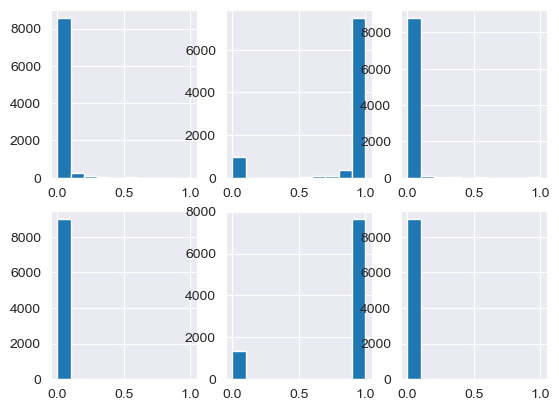

In [158]:
plt.subplot(2, 3, 1)
plt.hist([x[0] for x in df.loc[:,'bi_gram_score']])
plt.subplot(2, 3, 2)
plt.hist([x[1] for x in df.loc[:,'bi_gram_score']])
plt.subplot(2, 3, 3)
plt.hist([x[2] for x in df.loc[:,'bi_gram_score']])
plt.subplot(2, 3, 4)
plt.hist([x[0] for x in df.loc[:,'tri_gram_score']])
plt.subplot(2, 3, 5)
plt.hist([x[1] for x in df.loc[:,'tri_gram_score']])
plt.subplot(2, 3, 6)
plt.hist([x[2] for x in df.loc[:,'tri_gram_score']])
plt.show()

### Positive and negative analysis


In [164]:
pos_words = ['good', 'yes', 'it does', 'works', 'corect', 'perfect','work', 'efficient', 'functional', 'good', 'great', 'excellent', 'wonderful', 'certainly','probably', 'need', 'maybe', 'fantastic', 'awesome', 'outstanding', 'incredible', 'amazing', 'impressive', 'brilliant', 'magnificent', 'fantastic', 'fabulous', 'exceptional', 'delightful', 'charming', 'lovely', 'wonderful', 'perfect', 'fantastic', 'excellent', 'efficient', 'effective', 'reliable', 'trustworthy', 'valuable', 'beneficial', 'helpful', 'positive', 'optimistic', 'happy', 'joyful', 'cheerful', 'enthusiastic', 'supportive', 'encouraging', 'empowering', 'inspiring', 'creative', 'innovative', 'visionary', 'accomplished', 'successful', 'victorious', 'celebrated', 'prestigious', 'amazing']

neg_words = ['bad', 'poor', 'hate', 'worst', 'terrible', 'worst', 'awful', 'disappointing', 'dissapointed', 'broke','faulty', 'awful', 'it wont', "doesn't", 'does not', 'terrible', 'awful', 'horrible', 'unpleasant', 'frustrating', 'annoying', 'disappointing', 'unsatisfactory', 'inadequate', 'subpar', 'faulty', 'flawed', 'defective', 'broken', 'ineffective', 'inefficient', 'unreliable', 'untrustworthy', 'worthless', 'pointless', 'futile', 'hopeless', 'depressing', 'discouraging', 'disheartening', 'demoralizing', 'negative', 'pessimistic', 'unhappy', 'miserable', 'frustrating', 'stressful', 'infuriating', 'aggravating', 'exasperating', 'irritating', 'offensive', 'repulsive', 'disgusting', 'revolting', 'loathsome', 'detestable', 'abhorrent', 'repugnant', 'nauseating']

##
stemmer = SnowballStemmer('english')
pos_words = [stemmer.stem(word) for word in pos_words]
neg_words = [stemmer.stem(word) for word in neg_words]

##
def sentiment_score(text):

    pos_count = sum([1 for i in word_tokenize(text) if i in pos_words])
    neg_count = sum([1 for i in word_tokenize(text) if i in neg_words])

    try:
        pos_score = round((pos_count) / len(text), 2)
        neu_score =  round((len(text) - neg_count - pos_count) / len(text), 2)
        neg_score = round((neg_count) / len(text), 2)
    except ZeroDivisionError:
        pos_score = 0
        neu_score = 0
        neg_score = 0

    return pos_score, neu_score, neg_score

df['answer_light_clean'] = df['answer'].apply(cleaner)

df['sentiment_score'] = df['answer_light_clean'].apply(sentiment_score)
df.head()

,questionType,question,answerType,answer,question_word,question_clean,answer_clean,question_bigram,question_trigram,answer_bigram,answer_trigram,bi_gram_score,tri_gram_score,sentiment_score,answer_light_clean,target_manual
0,yes/no,I have a 9 year old Badger 1 that needs replac...,?,I replaced my old one with this without a hitch.,will,year old badger need replacing badger install ...,replaced old one without hitch,"[('year', 'old'), ('old', 'badger'), ('badger'...","[('year', 'old', 'badger'), ('old', 'badger', ...","[('replaced', 'old'), ('old', 'one'), ('one', ...","[('replaced', 'old', 'one'), ('old', 'one', 'w...","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","(0.0, 1.0, 0.0)",i replaced my old one with this without hitch,0.950000
1,open-ended,model number,NaN,This may help InSinkErator Model BADGER-1: Bad...,NaN,model number,may help insinkerator model badger badger hp g...,"[('model', 'number')]",[],"[('may', 'help'), ('help', 'insinkerator'), ('...","[('may', 'help', 'insinkerator'), ('help', 'in...","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","(0.01, 0.99, 0.0)",this may help insinkerator model badger 1 badg...,0.900000
2,yes/no,can I replace Badger 1 1/3 with a Badger 5 1/2...,?,Plumbing connections will vary with different ...,can,replace badger badger connection,plumbing connection vary different model usual...,"[('replace', 'badger'), ('badger', 'badger'), ...","[('replace', 'badger', 'badger'), ('badger', '...","[('plumbing', 'connection'), ('connection', 'v...","[('plumbing', 'connection', 'vary'), ('connect...","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","(0.0, 1.0, 0.0)",plumbing connections will vary with different ...,0.629159
3,yes/no,Does this come with power cord and dishwasher ...,?,It does not come with a power cord. It does co...,does,come power cord dishwasher hook,come power cord come dishwasher hookup,"[('come', 'power'), ('power', 'cord'), ('cord'...","[('come', 'power', 'cord'), ('power', 'cord', ...","[('come', 'power'), ('power', 'cord'), ('cord'...","[('come', 'power', 'cord'), ('power', 'cord', ...","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","(0.0, 1.0, 0.0)",it does not come with power cord it does come ...,0.910811
4,open-ended,loud noise inside when turned on. sounds like ...,NaN,Check if you dropped something inside.Usually ...,when,loud noise inside turned sound like blade loose,check dropped something insideusually wife put...,"[('loud', 'noise'), ('noise', 'inside'), ('ins...","[('loud', 'noise', 'inside'), ('noise', 'insid...","[('check', 'dropped'), ('dropped', 'something'...","[('check', 'dropped', 'something'), ('dropped'...","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","(0.0, 1.0, 0.0)",check if you dropped something inside usually ...,0.861473


In [165]:
df.loc[:200,'sentiment_score']

0        (0.0, 1.0, 0.0)
1      (0.01, 0.99, 0.0)
2        (0.0, 1.0, 0.0)
3        (0.0, 1.0, 0.0)
4        (0.0, 1.0, 0.0)
             ...        
196    (0.02, 0.98, 0.0)
197      (0.0, 1.0, 0.0)
198      (0.0, 1.0, 0.0)
199      (0.0, 1.0, 0.0)
200      (0.0, 1.0, 0.0)
Name: sentiment_score, Length: 201, dtype: object

In [168]:
df.loc[11,['question','answer','sentiment_score']]

question           so can this unit be connected with a dishwashe...
answer                                      yes, I did it with mine.
sentiment_score                                    (0.05, 0.95, 0.0)
Name: 11, dtype: object

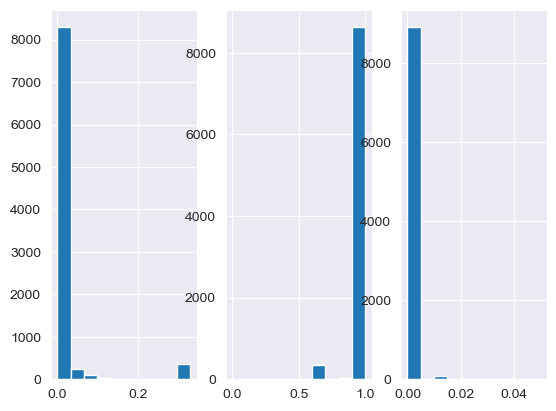

In [166]:
plt.subplot(1, 3, 1)
plt.hist([x[0] for x in df.loc[:,'sentiment_score']])
plt.subplot(1, 3, 2)
plt.hist([x[1] for x in df.loc[:,'sentiment_score']])
plt.subplot(1, 3, 3)
plt.hist([x[2] for x in df.loc[:,'sentiment_score']])
plt.show()

# Functions for main function
### Check for straight answers (yes, no etc) and answers with numbers (3, three), Spacy similarity between question and answer, extract n-grams(lite)

In [155]:
useful_words = ['yes', 'yea', 'sure', 'yep', 'yeah', 'indeed', 'certainly', 'definitely', 'cant', 'can', 'no', 'nope', 'nah']
un_words = ['unsure', 'never', 'maybe', 'could', 'probably', 'possibly']
word_nums = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'teen', 'twenty', 'thirty', 'fourty', 'fifty', 'hundered', 'thousand']

def check_numeric(question, answer):

    if bool(re.search('.*\d.*', answer)) or bool(set(word_tokenize(answer)) & set(word_nums)):
        use_score = 0.95
    elif len(word_tokenize(answer))<4:
        use_score = 0.92
    else:
        use_score = (qa_sim(question, answer)+1)/2

    return use_score

def check_yn(question, answer):

    if bool(set(word_tokenize(answer)) & set(useful_words)):
        use_score = 0.97
    else:
        use_score = check_numeric(question, answer)

    return use_score

nlp = spacy.load('en_core_web_md')
def qa_sim(question, answer):
    """
    Function to provide a similarity score between two sentences (question and answer).
    Input is a clean string, does NOT need to be tokenised.
    returned score is between -1 and 1
    """
    test_question = question
    test_answer = answer

    # Create a token for the test movie and initialise the highest coefficient marker
    q_token = nlp(test_question)
    a_token = nlp(test_answer)

    return q_token.similarity(a_token)

from nltk.util import ngrams

def extract_ngrams(data, num):
    n_grams = ngrams(word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]

### Less rigorous cleaner for scoring functions that run after the n-gram scoring (it protects useless bigrams also)

In [144]:
q_words = ['does', 'do', 'what', 'where', 'who', 'whom', 'which', 'whose', 'why', 'how', 'is', 'are', 'will', 'would', 'can', 'could', 'should',  'did', 'when','has', 'have', 'am', 'may']
yn_qs = ['is', 'are', 'will', 'would', 'can', 'could', 'should', 'may', 'does', 'do', 'did', 'has', 'have', 'am']
unsure_bigrams = ['dont know', 'not sure', 'might do', 'could maybe', 'no idea', 'not know', 'a clue']


# Main function
###### Psuedo code:
###### Take the score from n-gram analysis, if there is any matching n-grams set use_score = 1
###### For any useless bi-grams missed by for the first condition, set use score = 0
###### For any clear question (question word exists), if there is a yes/no or a number in the answer, set use_score = 1
###### For remaining answers, if there is an unuseful word, set use_score = 0.2
###### For remainig answer if they are 3 words or less, set use_score = 1
###### If there is no matching condition at the end, the score is calulated by using the similarity between the q&a and weighted by it's pos/neg or neutral sentiment

In [171]:
def useful_score(dframe):

    # Clean inputs
    question = cleaner(dframe['question'])
    answer = cleaner(dframe['answer'])

    if (dframe['tri_gram_score'][0] > 0) or (dframe['bi_gram_score'][0] > 0):
        # If there is a match between the answer's n-grams and the list of useful n-grams, use score is 1
        use_score = 1

    elif (dframe['tri_gram_score'][2] > 0) or (dframe['bi_gram_score'][2] > 0):
        # If there is a match between the answer's n-grams and the list of unuseful n-grams, use score is 0.1
        use_score = 0.1

    elif bool(set(extract_ngrams(answer, 2)) & set(unsure_bigrams)):
        # For any answer containing an 'unsure bigram', use_score = 0
        use_score = 0

    elif dframe['question_word'] in q_words:
        # For any clear question (i.e. with a question word), an answer with y/n or with a number, has use_score = 1. Otherwise, similarity score is given. In general, it was found that any answer with a number was useful, regardless of the question.
        use_score = check_yn(question, answer)

    elif bool(re.search('.*\d.*', answer)) or \
            bool(set(word_tokenize(answer)) & set(word_nums)) or \
            bool(set(word_tokenize(answer)) & set(useful_words)):
        # Any other answer with y/n or a number, use_score = 0.9
        use_score = 0.9

    elif bool(set(word_tokenize(answer)) & set(un_words)):
        # Any other answer with un-useful words has use_score = 0.2
        use_score = 0.2

    elif len(word_tokenize(answer))<4:
        # Any short answer (3 or fewer words) is usually useful
        use_score = 0.91
    else:
        # Any other answer is scored by similarity between Q and A, then weighted for positive/negative sentiment
        sim_score = (qa_sim(question,answer)+1)/2
        pos, neu, neg = sentiment_score(answer)
        if neu == 1:
            sentiment = 0.8
        else:
            sentiment = 1.2
        use_score = sim_score*sentiment
    return use_score


df['target_manual'] = df.apply(useful_score, axis=1)

/var/folders/b7/kmbr2qfj1fd5c0wjsnnd0jtw0000gn/T/ipykernel_48277/2414828757.py:39: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return q_token.similarity(a_token)


In [78]:
df['target_manual'].value_counts().head(20)

1.000000    7151
0.900000     166
0.950000      12
0.200000       9
0.728504       5
0.784204       5
0.932021       5
0.749615       5
0.904883       3
0.872003       3
0.815645       2
0.818283       2
0.827857       2
0.798601       2
0.868312       2
0.763228       2
0.843540       2
0.844701       2
0.718361       2
0.864331       2
Name: target_manual, dtype: int64

In [175]:
df.sort_values(by='target_manual').reset_index().loc[1500:1700,['question','answer','target_manual']]

,question,answer,target_manual
1500,Does the fridge have sides or is it just the r...,Just insulation on sides.,0.855255
1501,"My whirlpool washer model is WFW9150WW01, will...",Worked well for me. If you are not good with t...,0.855309
1502,"The blue, not the purple are the real ones, ri...",The ones I got were the blue ones and I couldn...,0.855445
1503,will these fit my jenn air model c202 cooktop?,they are standard size and should fit all mode...,0.855466
1504,"Is the vent opening compatible with 6"" or 8""? ...",The response for confusion is the seller switc...,0.855590
...,...,...,...
1696,I get a puddle of water on the floor when I us...,Not enough info.Are you talking about the back...,0.874278
1697,Can this dishwasher sit on top of counter? Are...,The sides are not finished. This model is made...,0.874324
1698,"to confirm, the refrig will be delivered into ...",you need to pay for installation to have every...,0.874467
1699,Is this product compatible with the AOS 7144 w...,The Hydrostick was made with silver that actua...,0.874526


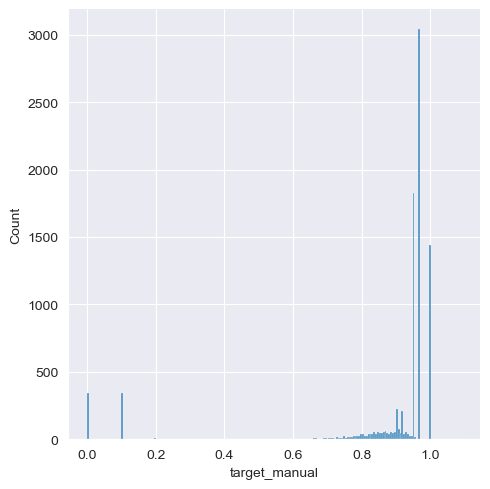

In [172]:
sns.displot(df['target_manual'])
plt.show()

In [176]:
df['target_thresh'] = np.where(df['target_manual']>.85, 1, 0)

In [179]:
df_test = df.iloc[1,:]
def answer_use_score(question, answer):
    df_test['question'] = question
    df_test['answer'] = answer
    useful_score(df_test)
    return df_test['target_manual']

q = 'Would you recommend this hardcover version of the book, since it\'s a bit more expensive?'
a = 'The book was absolutely AMAZING! Easily one of my favourite lectures so far this year. The story was highly immersive and (without giving away spoilers!) the character development the main trio was done excellently.'

answer_use_score(q,a)

/var/folders/b7/kmbr2qfj1fd5c0wjsnnd0jtw0000gn/T/ipykernel_48277/2340307380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['question'] = question
/var/folders/b7/kmbr2qfj1fd5c0wjsnnd0jtw0000gn/T/ipykernel_48277/2340307380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['answer'] = answer


0.9